In [56]:
import os
import subprocess
import time
from datetime import datetime
from influxdb import InfluxDBClient
import pandas as pd
import matplotlib.pyplot as plt

In [57]:
SERVER_CMD = "audita-worker"
K6_SCRIPT = "k6.js"
INFLUXDB_HOST = "localhost"
INFLUXDB_PORT = 8086
INFLUXDB_DB = 'k6'
SERVER_LOG = "server.log"
INFLUXDB_URL = f'http://{INFLUXDB_HOST}:{INFLUXDB_PORT}/{INFLUXDB_DB}'

In [58]:
configurations = [
    {'batch': 50},
    {'batch': 100},
    {'batch': 500},
    {'batch': 1000},
]
reports = []

In [59]:
client = InfluxDBClient(
    host=INFLUXDB_HOST,
    port=INFLUXDB_PORT,
    database=INFLUXDB_DB
)

In [60]:
for config in configurations:
    batch = config['batch']

    env = os.environ.copy()
    env['BATCH_SIZE'] = str(batch)


    with open(SERVER_LOG, 'a') as log:
        server_process = subprocess.Popen(
            f"{SERVER_CMD} --batch {batch}",
            env=env,
            stdout=log,
            stderr=subprocess.STDOUT,
            shell=True,
            text=True
        )

    time.sleep(3)

    start_time = datetime.now()

    try:
        subprocess.run([
            'k6', 'run', K6_SCRIPT,
            '--out', f'influxdb={INFLUXDB_URL}',
            '--tag', f'config=Batch:{batch}'
        ], check=True)

    finally:
        end_time = datetime.now()
        server_process.terminate()
        server_process.wait()
        time.sleep(1)

    reports.append((start_time, end_time, config))


         /\      Grafana   /‾‾/  
    /\  /  \     |\  __   /  /   
   /  \/    \    | |/ /  /   ‾‾\ 
  /          \   |   (  |  (‾)  |
 / __________ \  |_|\_\  \_____/ 

     execution: local
        script: k6.js
        output: InfluxDBv1 (http://localhost:8086)

     scenarios: (100.00%) 1 scenario, 1000 max VUs, 1m30s max duration (incl. graceful stop):
              * default: 1000 looping VUs for 1m0s (gracefulStop: 30s)


running (0m00.9s), 1000/1000 VUs, 0 complete and 0 interrupted iterations
default   [   2% ] 1000 VUs  0m00.9s/1m0s

running (0m01.9s), 1000/1000 VUs, 1000 complete and 0 interrupted iterations
default   [   3% ] 1000 VUs  0m01.9s/1m0s

running (0m02.9s), 1000/1000 VUs, 1220 complete and 0 interrupted iterations
default   [   5% ] 1000 VUs  0m02.9s/1m0s

running (0m03.9s), 1000/1000 VUs, 1220 complete and 0 interrupted iterations
default   [   7% ] 1000 VUs  0m03.9s/1m0s

running (0m04.9s), 1000/1000 VUs, 1270 complete and 0 interrupted iterations
default   [

In [61]:
reports

[(datetime.datetime(2025, 3, 15, 16, 21, 41, 490240),
  datetime.datetime(2025, 3, 15, 16, 23, 1, 458806),
  {'batch': 50}),
 (datetime.datetime(2025, 3, 15, 16, 23, 6, 766009),
  datetime.datetime(2025, 3, 15, 16, 24, 16, 963617),
  {'batch': 100}),
 (datetime.datetime(2025, 3, 15, 16, 24, 22, 271803),
  datetime.datetime(2025, 3, 15, 16, 25, 24, 754548),
  {'batch': 500}),
 (datetime.datetime(2025, 3, 15, 16, 25, 30, 61477),
  datetime.datetime(2025, 3, 15, 16, 26, 30, 556088),
  {'batch': 1000})]

In [62]:
def http_reqs_grouped_by_time(start_time, end_time):
    start_rfc = start_time.astimezone().isoformat('T', 'seconds')
    end_rfc = end_time.astimezone().isoformat('T', 'seconds')

    query = f"""
    SELECT
        sum(value)
    FROM http_reqs
    WHERE time > '{start_rfc}'
        AND time < '{end_rfc}'
    GROUP BY time(1s)
    """

    try:
        result = client.query(query)
        return result.get_points()

    except Exception as e:
        print(f"❌ Erro na consulta: {str(e)}")

def http_req_duration_grouped_by_time(start_time, end_time):
    start_rfc = start_time.astimezone().isoformat('T', 'seconds')
    end_rfc = end_time.astimezone().isoformat('T', 'seconds')

    query = f"""
    SELECT
        mean(value)
    FROM http_req_duration
    WHERE time > '{start_rfc}'
        AND time < '{end_rfc}'
    GROUP BY time(1s)
    """

    try:
        result = client.query(query)
        return result.get_points()

    except Exception as e:
        print(f"❌ Erro na consulta: {str(e)}")

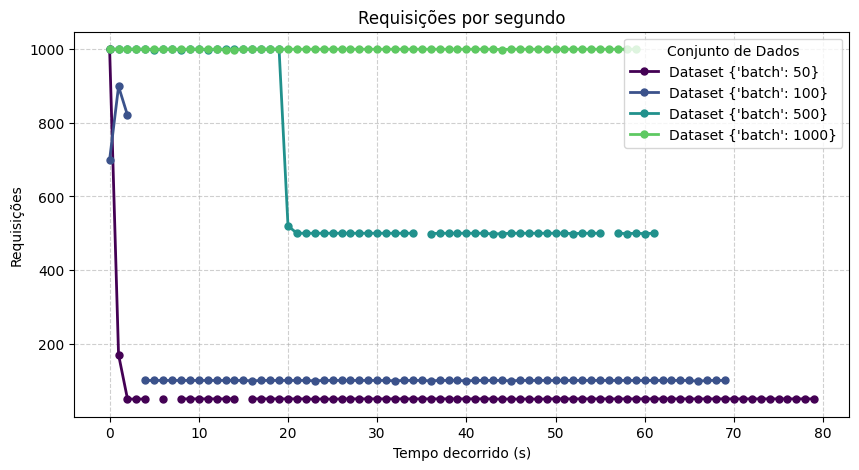

In [67]:
#plt.style.use('seaborn-v0_8-darkgrid')
plt.rcdefaults()
plt.figure(figsize=(10, 5))

for i, report in enumerate(sorted(reports)):
    http_reqs = http_reqs_grouped_by_time(report[0], report[1])
    df = pd.DataFrame(http_reqs)

    color = plt.cm.viridis(i / len(reports))

    plt.plot(df.index, df['sum'],
             marker="o", linestyle="-", linewidth=2, markersize=5,
             label=f"Dataset {report[2]}", color=color)

plt.xlabel("Tempo decorrido (s)", fontsize=10)
plt.ylabel("Requisições", fontsize=10)
plt.title("Requisições por segundo", fontsize=12)
plt.legend(title="Conjunto de Dados", fontsize=10)
plt.grid(linestyle="--", alpha=0.6)
plt.show()


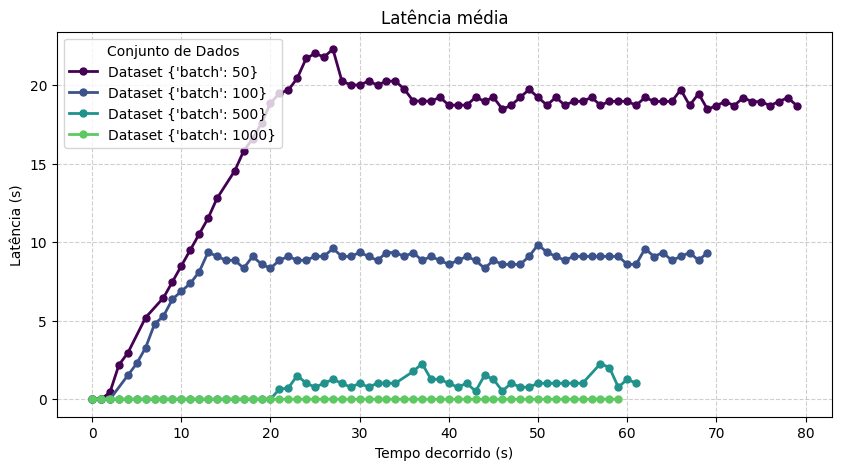

In [ ]:
#plt.style.use('seaborn-v0_8-darkgrid')
plt.figure(figsize=(10, 5))

for i, report in enumerate(sorted(reports)):
    http_req_duration = http_req_duration_grouped_by_time(report[0], report[1])
    df = pd.DataFrame(http_req_duration)

    df = df.dropna()

    color = plt.cm.viridis(i / len(reports))

    # Plotar cada segmento contínuo separadamente
    x = df.index
    y = df['mean'] / 1000

    # Identificar onde há descontinuidades (buracos)
    diff = np.diff(x)
    gaps = np.where(diff > 1)[0]  # Assumindo que o tempo é em segundos e há descontinuidades

    # Dividir os dados em segmentos contínuos
    segments = np.split(np.arange(len(x)), gaps + 1)

    for segment in segments:
        if len(segment) > 1:  # Plotar apenas segmentos com mais de um ponto
            plt.plot(x[segment], y[segment],
                     marker="o", linestyle="-", linewidth=2, markersize=5,
                     color=color)

    # Adicionar label apenas uma vez por conjunto de dados
    if len(x) > 0:
        plt.plot(df.index, df['mean']/1000,
             marker="o", linestyle="-", linewidth=2, markersize=5,
             label=f"Dataset {report[2]}", color=color,  drawstyle='default')

plt.xlabel("Tempo decorrido (s)", fontsize=10)
plt.ylabel("Latência (s)", fontsize=10)
plt.title("Latência média", fontsize=12)
plt.legend(title="Conjunto de Dados", fontsize=10)
plt.grid(linestyle="--", alpha=0.6)

plt.show()